In [1]:
import os
import glob
import numpy as np
import torch
import torchvision
from PIL import Image, ImageDraw
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [2]:
from decouple import config

BASE_DIR = config('BASE_DIR', default='', cast=str)
dataset_path = os.path.join(BASE_DIR, 'data-science-bowl-2018')
models_path = os.path.join(BASE_DIR, "models")

In [3]:
import cv2


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image, targets):

        h, w = image.shape[:2]
        if (h, w) == self.output_size:
            return image, targets
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # image = np.resize(image, (new_h, new_w, 3))
        image = cv2.resize(image, dsize=(new_h, new_w), interpolation=cv2.INTER_CUBIC)

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        ratio_height = new_h / h
        ratio_width = new_w / w

        xmin, ymin, xmax, ymax = targets[0]["boxes"].unbind(1)

        xmin = xmin * ratio_width
        xmax = xmax * ratio_width
        ymin = ymin * ratio_height
        ymax = ymax * ratio_height

        targets[0]["boxes"] = torch.stack((xmin, ymin, xmax, ymax), dim=1)

        return image, targets


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        landmarks = landmarks[0]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top, left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image, targets):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        return image, targets


class Compose(object):
    """Composes several transforms together.

    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.

    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, targets):
        for t in self.transforms:
            image, targets = t(image, targets)
        return image, targets


In [4]:
import os
import glob
import numpy as np
import torch
from PIL import Image, ImageDraw
from skimage import draw
from skimage.io import imread
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T


dataset_path = os.path.join(BASE_DIR, 'data-science-bowl-2018')


def get_transform(train=False):
    transforms = []
    if train:
        transforms.append(Rescale((256, 256)))
    transforms.append(ToTensor())
    return Compose(transforms)


class MyDataset(Dataset):
    def __init__(self, transforms=None, split="stage1_train", path=dataset_path):
        self.split = split
        self.path = path + '/' + split

        self.transforms = transforms

        self.path_id_list = glob.glob(os.path.join(self.path, '*'))
        self.id_list = []
        self.image_list = []
        self.mask_list = []

        for path_id in self.path_id_list:
            images = glob.glob(path_id + '/images/*png')
            masks = glob.glob(path_id + '/masks/*png')
            self.id_list.append(os.path.basename(path_id))
            self.image_list.extend(images)
            self.mask_list.append(masks)

    def __len__(self):
        return len(self.path_id_list)

    def __getitem__(self, index):
        image = np.array(Image.open(self.image_list[index]), dtype=np.uint8)
        image = image[:, :, :3]  # remove alpha channel
        boxes, labels = self.mask_to_bbox(self.mask_list[index])
        targets = [
            {
                'boxes': torch.FloatTensor(boxes),
                'labels': torch.LongTensor(labels),
                'name': self.id_list[index]
            }
        ]

        if self.transforms is not None:
            image, targets = self.transforms(image, targets)

        return image, targets

    def mask_to_bbox(self, mask_paths):
        boxes = []
        labels = []
        for path in mask_paths:
            mask = Image.open(path)
            mask = np.array(mask)
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin != xmax and ymin != ymax:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(1)  # every mask is cell
        return boxes, labels


In [8]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be ['0']. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                             output_size=7,
                                             sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(
                backbone,
                num_classes=2,
                rpn_anchor_generator=anchor_generator,
                box_roi_pool=roi_pooler,
                min_size=256,
                max_size=256,
                  )


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}...")

Running on cpu...


In [10]:
dataset = MyDataset(split='stage1_train', transforms=get_transform(train=True))

In [11]:
model.load_state_dict(torch.load(os.path.join(models_path, "faster_rcnn2.pt"), map_location=device))

<All keys matched successfully>

In [26]:
image, targets = dataset[88]

In [27]:
image = image[None, :, :, :]
image = image.to(device=device)
targets = [{
        "boxes": targets[0]["boxes"].to(device=device),
        "labels": targets[0]["labels"].to(device=device)
        }]

In [28]:
model.eval()
prediction = model(image)

In [29]:
image2 = Image.fromarray(image.cpu().numpy()[0, 0, :, :])
if image2.mode != "RGB":
    image2 = image2.convert("RGB")
draw = ImageDraw.Draw(image2)
for box, score in zip(prediction[0]["boxes"], prediction[0]["scores"]):
    x0, y0, x1, y1 = box
    draw.rectangle([(x0, y0), (x1, y1)], outline=(255, 0, 255))
image2.show()

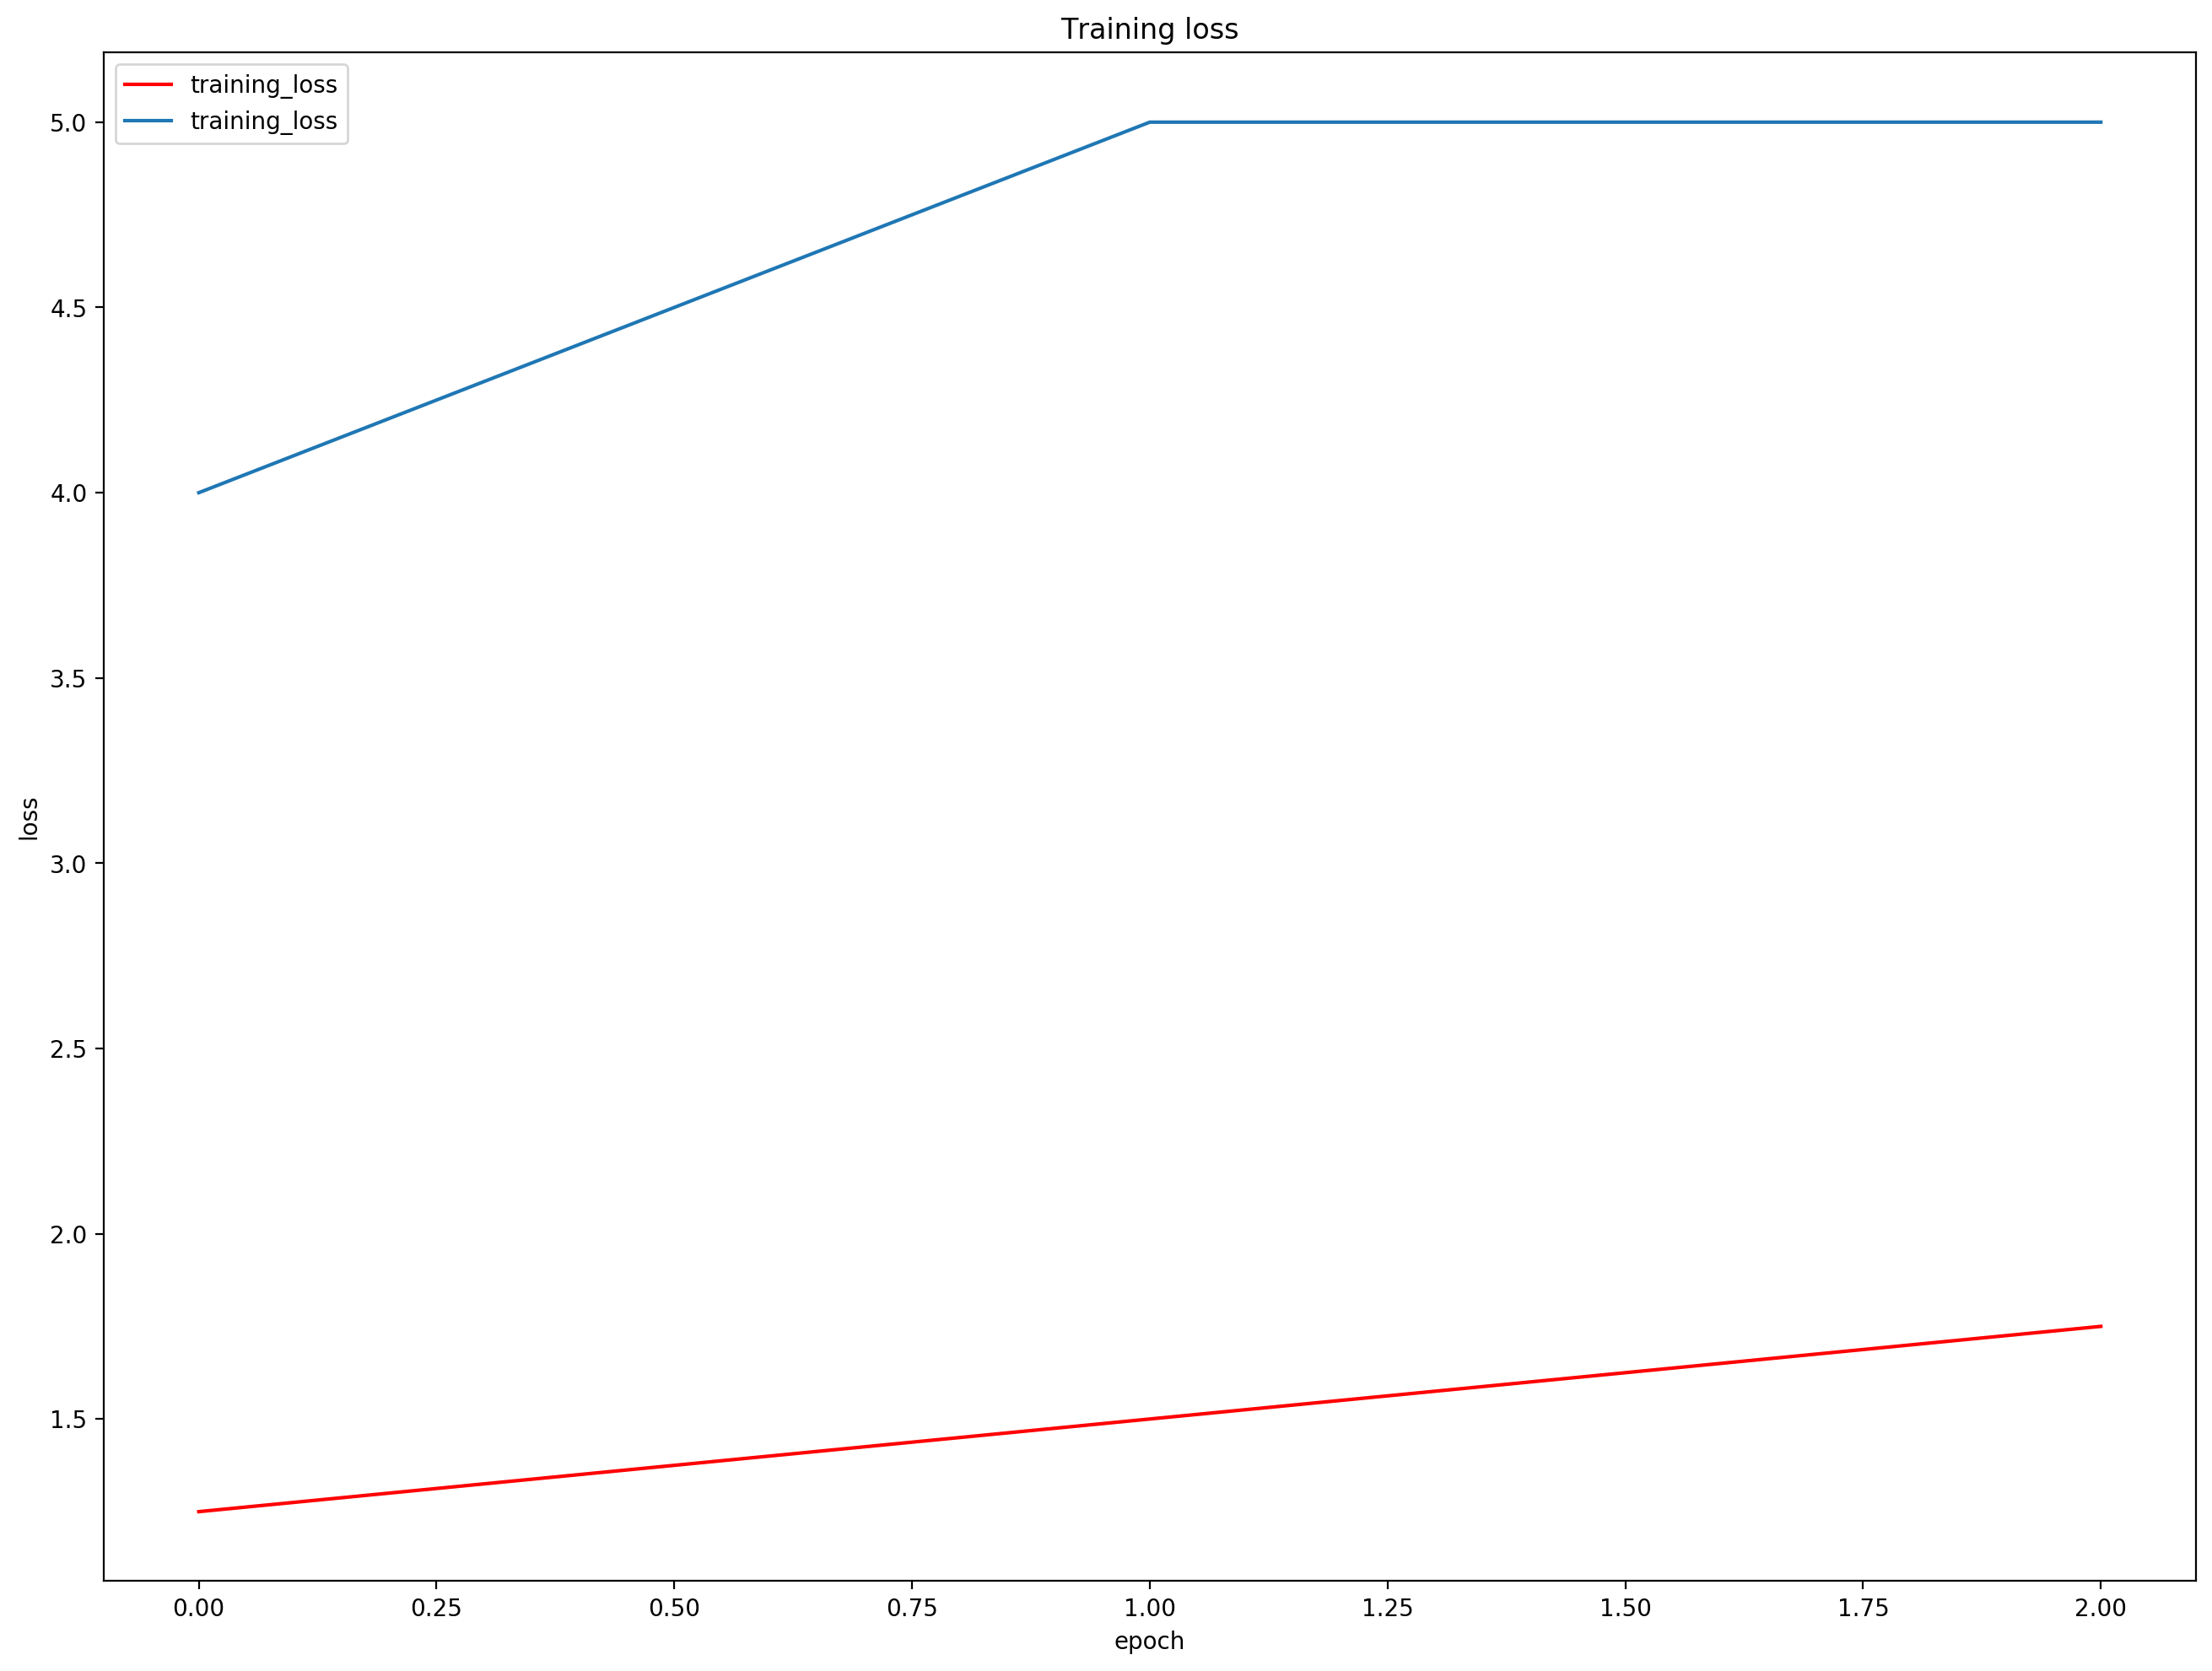

In [43]:
list1 = [5, 6, 7]
list1 = [x / 4 for x in list1]
list2 = [4, 5, 5]
plt.figure(figsize=(16, 12), dpi=200)
plt.plot(list1, 'r-', label="training_loss")
plt.plot(list2, label="training_loss")
plt.title("Training loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()